<h1>Strategies to prevent overfitting in neural networks</h1>

In [184]:
%matplotlib inline

import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

try:
    tf.set_random_seed(1337)                    # set the random seed for reproducibility
except:
    tf.random.set_seed(1337)                     # NOTE: Newer version of tensorflow uses tf.random.set_seed
np.random.seed(1337)                         #       instead of tf.set_random_seed

<h2>Introduction</h2>
<p><strong>Business Context.</strong> You are a data scientist working for a machine learning consultancy. One of your clients wants to be able to classify text reviews automatically by the likely rating (on a 1 - 5 scale) that that person would give. However, they do not have sufficient data they generated on their own to do this, so you need to use an external, rich dataset as a basis on which to build your model and then translate it over.</p>
<p><strong>Business Problem.</strong> Your task is to <strong>build a neural networks-based model for classifying text reviews into likely ratings (on a 1 - 5 scale)</strong>.</p>
<p><strong>Analytical Context.</strong> We'll use the Amazon review dataset again and try to classify reviews into star ratings automatically. Instead of just positive and negative, we'll take on the harder challenge of predicting the <em>exact</em> star rating. The lowest score is 1 and the highest is 5.</p>
<p>Instead of trying to optimize by pre-processing the text, we'll do very basic tokenization and experiment with different neural network models, architectures, and hyperparameters to optimize the results. You'll start by building a simple dense neural network and try to get it to perform better using various techniques. Then you'll evaluate the results and diagnose where it tends to perform more poorly.</p>

<h2>Setting up and preparing the data</h2>
<p>We'll mainly be using the <code>keras</code> module from TensorFlow, but we'll also use <code>pandas</code> to read the CSV file and <code>sklearn</code> for some helper functions. We'll be using only the "Text" and "Score" columns in the <code>Reviews.csv</code> file:</p>

In [185]:
amazon_reviews = pd.read_csv('Reviews.csv', nrows=262084)
amazon_reviews.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


<h3>Exercise 1:</h3>
<p>Combine the first 1,000 of each of the 1-, 2-, 3-, 4-, and 5-star reviews in <code>amazon_reviews</code> into a single DataFrame (so you should have 5,000 observations in total). Split this DataFrame into training and test sets, with 80% of the data for the training set.</p>
<p><strong>Hint:</strong> <code>keras</code> will expected your labels to start with 0, and not 1, so make sure to adjust the labels accordingly.</p>

**Answer.**

In [186]:
#we filter the data-set with only text and score
amazon_review = amazon_reviews[["Score","Text"]]
amazon_review

,Score,Text
0,5,I have bought several of the Vitality canned d...
1,1,Product arrived labeled as Jumbo Salted Peanut...
2,4,This is a confection that has been around a fe...
3,2,If you are looking for the secret ingredient i...
4,5,Great taffy at a great price. There was a wid...
...,...,...
262079,1,Bought Lucy's cookies after I heard about them...
262080,3,I am not sure what I expected but I found the ...
262081,1,SO disappointed off taste all the flavors tast...
262082,2,"If you have to eat gluten free, these cookies ..."


In [383]:
#we create the dataframe 
score_one  = amazon_review[amazon_review["Score"]==1][0:1000]
score_one["Score"]=0
score_two  = amazon_review[amazon_review["Score"]==2][0:1000]
score_two["Score"]=1
score_three  = amazon_review[amazon_review["Score"]==3][0:1000]
score_three["Score"]=2
score_four  = amazon_review[amazon_review["Score"]==4][0:1000]
score_four["Score"]=3
score_five  = amazon_review[amazon_review["Score"]==5][0:1000]
score_five["Score"]=4


scores = pd.concat([score_one,score_two,score_three,score_four,score_five],ignore_index= True)

# Now  I divided the dataset in two groups: Train and Test    random_state = 0
train, test = train_test_split(scores, test_size = 0.2, random_state = np.random.seed(1337))

scores
#x_train, y_train , x_test, y_test = train_test_split(scores, test_size = 0.2, random_state = np.random.seed(1337))

,Score,Text
0,0,Product arrived labeled as Jumbo Salted Peanut...
1,0,My cats have been happily eating Felidae Plati...
2,0,"The candy is just red , No flavor . Just plan..."
3,0,"This oatmeal is not good. Its mushy, soft, I d..."
4,0,Arrived in 6 days and were so stale i could no...
...,...,...
4995,4,i followed the easy instructions and these tur...
4996,4,WE LOVE LOVE LOVE these muffins. They are mois...
4997,4,I brought 2 bottles. One I carry in my pocket...
4998,4,I really like this soup. It is mild and I don...


In [7]:
# This is another form
#x_train, x_test, y_train, y_test = train_test_split(scores.Text,scores.Score, test_size=0.2, random_state=np.random.seed(1337))
#print("number of test samples :", x_test.shape[0])
#print("number of training samples:",x_train.shape[0])

<h2>Tokenizing our texts</h2>
<p>Keras comes with its own functions to preprocess text, including a <a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer">tokenizer</a> (a mapping from each word in our corpus to a unique integer). Unlike the <code>CountVectorizer</code> from <code>sklearn</code>, which produces sparse matrices, <code>keras</code> often expects to work with sequences representing only the words that occur in a text. To prepare text before feeding it into a neural network, we usually:</p>
<ol>
<li>Create a <a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer">tokenizer</a>.</li>
<li><a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer#texts_to_sequences">Create sequences</a> from our text (each text becomes a list of integers, based on the tokenizer mapping, instead of words)</li>
<li><a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences">Pad or truncate</a> each sequence to a fixed length (very short texts get <code>0</code>s added to them, while very long ones are truncated).</li>
</ol>
<p>The tokenizer has a configurable word cap, so it will only consider the $n$ most common words in the corpus, ignoring very rare words.</p>

<h3>Exercise 2:</h3>
<p>In this exercise, you will learn how to use the <code>tf.keras.preprocessing.text.Tokenizer</code> tool to carry out the preprocessing steps described above.</p>
<h4>2.1</h4>
<p>Perform some exploratory analysis of the dataset to calculate the number of unique words in our corpus and the distribution of the number of words in each review of the training set. What is the 80th percentile of this distribution?</p>

**Answer.**

116.0

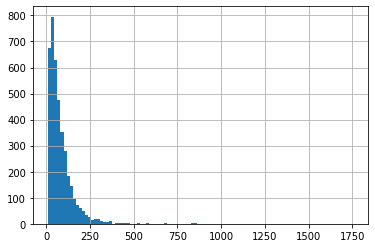

In [188]:
#First I had random_state=tf.random.set_seed(1337), then I changed it to random_state=np.random.seed(1337) and worked
words_per_review_train =train.Text.apply(lambda x: len(x.split()))
words_per_review_train.hist(bins = 100)

words_per_review_train.quantile(0.8)

<h4>2.2</h4>
<p>Given the results above, we create a tokenizer using only the top 20,000 most frequent words in our corpus (which corresponds to roughly 80% of the words): </p>

In [189]:
tokenizer = Tokenizer(num_words=20000) #We create the tokenizer using only top 20000 words

In [190]:
tokenizer.fit_on_texts(train['Text'])  #Then, we create the text->indices mapping. 

The above line has given several features and methods to our tokenizer. For instance, print the line `tokenizer.word_index` in a new cell - what do you see? Apply the `tokenizer.texts_to_sequences()` method on the list `['I just feel very very good']`. Apply the `tokenizer.sequences_to_texts()` method on the list `[[109, 19, 824, 76, 114, 6315, 1137, 8070]]`. What were your results?

**Answer.**

In [191]:
tokenizer.word_index

{'the': 1,
 'i': 2,
 'a': 3,
 'and': 4,
 'to': 5,
 'it': 6,
 'of': 7,
 'br': 8,
 'is': 9,
 'this': 10,
 'in': 11,
 'for': 12,
 'but': 13,
 'that': 14,
 'not': 15,
 'my': 16,
 'was': 17,
 'with': 18,
 'you': 19,
 'have': 20,
 'are': 21,
 'they': 22,
 'as': 23,
 'like': 24,
 'on': 25,
 'so': 26,
 'these': 27,
 'be': 28,
 'taste': 29,
 'if': 30,
 'coffee': 31,
 'good': 32,
 'product': 33,
 'them': 34,
 'or': 35,
 'just': 36,
 'at': 37,
 'all': 38,
 'very': 39,
 'one': 40,
 'would': 41,
 'flavor': 42,
 "it's": 43,
 'can': 44,
 'from': 45,
 'had': 46,
 'more': 47,
 'when': 48,
 'me': 49,
 'will': 50,
 'out': 51,
 'than': 52,
 'has': 53,
 'other': 54,
 'no': 55,
 'great': 56,
 'were': 57,
 'much': 58,
 'we': 59,
 'really': 60,
 'too': 61,
 "don't": 62,
 'only': 63,
 'some': 64,
 'up': 65,
 'there': 66,
 'get': 67,
 'because': 68,
 'about': 69,
 'chips': 70,
 'an': 71,
 'better': 72,
 'amazon': 73,
 'what': 74,
 'tea': 75,
 'your': 76,
 'sugar': 77,
 'which': 78,
 'buy': 79,
 'little': 80,
 '

In [192]:
tokenizer.texts_to_sequences(['I just feel very very good'])

[[2, 36, 351, 39, 39, 32]]

In [193]:
tokenizer.sequences_to_texts([[109, 19, 824, 76, 114, 6315, 1137, 8070]])

['did you miss your best data science professor']

<h4>2.3</h4>
<p>Use the tokenizer to transform the texts in our test and train data to sequences. Then, use the <code>pad_sequences</code> function to pad/truncate these sequences to length 116 (the 80th percentile of text lengths). Save the resulting arrays as <code>train_sequences</code> and <code>test_sequences</code>.</p>

**Answer.**

In [194]:
train.Text

4614    This gravy mix is excellent ... except, don't ...
607     I bought a box, waist'd my $$ but people love ...
4219    These creamers come in 4 packs of 25. I have t...
3547    I bought the Blue Icicle because I had to quic...
3876    This tea makes extremely dark and strong tea o...
                              ...                        
3239    I loved this product, and it was better than w...
1256    I ordered these despite my concerns after read...
860     The coffee tasted bitter and like it was burnt...
189     you won't BELIEVE how many ways this product h...
3223    Possibly THE best salt and vinegar chips (heal...
Name: Text, Length: 4000, dtype: object

In [195]:
# we use the tokenizer to transform the texts in our train data to sequences
sequence_train = tokenizer.texts_to_sequences(train.Text)
#sequence_train

In [196]:
# we obtein the array
train_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequence_train,maxlen=116)
train_sequences.shape

(4000, 116)

In [197]:

# we use the tokenizer to transform the texts in our test data to sequences
sequence_test = tokenizer.texts_to_sequences(test.Text)
# We obtein the array
test_sequences = tf.keras.preprocessing.sequence.pad_sequences(sequence_test,maxlen=116)
test_sequences.shape


(1000, 116)

<h2>Building a basic neural network model</h2>
<p>Now that we have preprocessed the text, let's create a basic neural network to train on our data. We'll use an embedding layer which performs <a href="https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/">one-hot encoding</a> on our word sequences, two fully connected ("dense") layers, and an output layer with 5 neurons to represent the 5 possible star ratings.</p>
<p>Before we train a <code>keras</code> model, there is an additional <code>compile</code> step where we define what loss function and optimizer to use, and what metrics to output. Then we can train the model using the <code>fit</code> function. All of this is shown below.</p>
<p>Note the <code>validation_split=0.2</code> argument which tells Keras to train on only 80% of the training data and tune the model on the remaining 20%, which we call the validation set. You can see the accuracy and loss for both the training and validation set in the output for each epoch:</p>

In [198]:
model = Sequential()
model.add(Embedding(20000, 128, input_length=116))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 116, 128)          2560000   
_________________________________________________________________
dense (Dense)                (None, 116, 128)          16512     
_________________________________________________________________
dense_1 (Dense)              (None, 116, 128)          16512     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 2,593,669
Trainable params: 2,593,669
Non-trainable params: 0
_________________________________________________________________


In [199]:
train

,Score,Text
4614,4,"This gravy mix is excellent ... except, don't ..."
607,0,"I bought a box, waist'd my $$ but people love ..."
4219,4,These creamers come in 4 packs of 25. I have t...
3547,3,I bought the Blue Icicle because I had to quic...
3876,3,This tea makes extremely dark and strong tea o...
...,...,...
3239,3,"I loved this product, and it was better than w..."
1256,1,I ordered these despite my concerns after read...
860,0,The coffee tasted bitter and like it was burnt...
189,0,you won't BELIEVE how many ways this product h...


In [201]:
# We create the arrays numpy
# This is another form : labels1=train.Score.to_numpy()

labels = np.array(np.array(train.Score))
labels

array([4, 0, 4, ..., 0, 0, 3], dtype=int64)

In [202]:
model.fit(train_sequences, labels, validation_split=0.2, epochs=10)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 4s 1ms/sample - loss: 1.5802 - acc: 0.2747 - val_loss: 1.5186 - val_acc: 0.3587
Epoch 2/10
3200/3200 [==============================] - 4s 1ms/sample - loss: 1.3718 - acc: 0.4297 - val_loss: 1.2999 - val_acc: 0.4725
Epoch 3/10
3200/3200 [==============================] - 4s 1ms/sample - loss: 1.0587 - acc: 0.5784 - val_loss: 1.2185 - val_acc: 0.5163
Epoch 4/10
3200/3200 [==============================] - 4s 1ms/sample - loss: 0.7233 - acc: 0.7441 - val_loss: 1.2806 - val_acc: 0.5050
Epoch 5/10
3200/3200 [==============================] - 4s 1ms/sample - loss: 0.4182 - acc: 0.8788 - val_loss: 1.4395 - val_acc: 0.4750
Epoch 6/10
3200/3200 [==============================] - 4s 1ms/sample - loss: 0.2158 - acc: 0.9572 - val_loss: 1.6261 - val_acc: 0.4787
Epoch 7/10
3200/3200 [==============================] - 4s 1ms/sample - loss: 0.1059 - acc: 0.9822 - val_loss: 1.7737 - val_acc: 0.4650
E

<h3>Exercise 3:</h3>
<p>How well does this model perform? How does this compare to a baseline expectation? What do you notice about the accuracy and loss values for both the validation and training sets over time and what does this mean?</p>

**Answer.**

We can observe that for the training set, the loss values decrease with time, while the accuracy values increase, approaching very close to 1, which means that it is good, however for the validation set it is observed that the Loss values decrease to some extent, but then start to increase. In the same way, it is observed that for the accuracy values, they never improve, there are always almost constants around 0.4. This means that the network does not perform as well when using the validation set.

In [203]:
#X_test_std = scaler.transform(test.Text)
import math
y_test = test.Score.to_numpy()
loss ,acc = model.evaluate(test_sequences, y_test)

print("Accurancy: ", acc)

1000/1000 [==============================] - 0s 151us/sample - loss: 2.3488 - acc: 0.4370
Accurancy:  0.437


**Accuracy tells us that the model that was applied applied to data that the model had never seen before, predicts 43.7% of them correctly.**

In [204]:
# WE predict the output with the test set
#a = model.predict_proba(test_sequences)

probabilities = model.predict_proba(test_sequences)
values = model.predict(test_sequences)
values

array([[0.0000000e+00, 2.3841858e-07, 3.2961369e-05, 1.1435151e-04,
        4.7683716e-07],
       [9.0569258e-04, 3.5610199e-03, 6.4998865e-05, 2.7829409e-04,
        1.2171507e-02],
       [1.3411045e-06, 1.4901161e-07, 6.1839819e-05, 6.0576200e-04,
        3.8743019e-07],
       ...,
       [0.0000000e+00, 2.2351742e-06, 2.5099516e-03, 9.9539757e-06,
        3.0100346e-06],
       [8.6426735e-06, 1.3411045e-06, 1.2725592e-05, 1.3759732e-04,
        3.9296150e-03],
       [2.3841858e-07, 2.9802322e-08, 3.5762787e-07, 2.4383366e-03,
        1.3588905e-02]], dtype=float32)

In [205]:
array_predict = np.argmax(values , axis=-1)

In [206]:
lis = []
for x,y in enumerate(values):
    index_max = np.argmax(values[x])
    lis.append(index_max)
    
    
array_predict = np.array(lis)
#array_predict

In [207]:
y_test

array([3, 4, 3, 4, 3, 2, 3, 1, 4, 1, 4, 0, 0, 3, 3, 3, 1, 2, 3, 2, 1, 3,
       0, 0, 4, 2, 0, 3, 0, 2, 3, 2, 2, 1, 4, 1, 1, 3, 3, 3, 4, 4, 2, 1,
       1, 0, 2, 2, 1, 2, 1, 4, 1, 4, 2, 0, 3, 2, 0, 2, 4, 3, 2, 4, 4, 0,
       4, 1, 1, 4, 3, 4, 1, 1, 2, 1, 1, 4, 3, 0, 3, 4, 4, 0, 3, 0, 4, 3,
       2, 2, 3, 3, 4, 0, 3, 4, 1, 3, 0, 0, 0, 3, 0, 0, 1, 2, 1, 3, 3, 4,
       3, 4, 2, 2, 0, 3, 1, 3, 4, 3, 1, 1, 0, 4, 2, 4, 1, 3, 0, 4, 2, 1,
       1, 0, 4, 0, 1, 4, 4, 2, 3, 0, 4, 0, 4, 0, 0, 2, 4, 2, 1, 2, 4, 4,
       4, 2, 4, 0, 3, 0, 4, 1, 4, 4, 3, 4, 0, 1, 3, 4, 0, 2, 2, 0, 2, 2,
       0, 1, 0, 2, 4, 3, 4, 3, 4, 3, 4, 4, 3, 0, 1, 2, 1, 4, 1, 4, 3, 1,
       0, 3, 0, 1, 2, 1, 3, 2, 1, 0, 0, 3, 3, 4, 3, 0, 4, 0, 4, 2, 3, 4,
       2, 1, 4, 3, 1, 1, 1, 4, 3, 0, 0, 0, 3, 1, 2, 0, 0, 2, 1, 0, 1, 3,
       2, 1, 3, 2, 0, 3, 1, 2, 4, 3, 0, 4, 3, 2, 1, 3, 4, 0, 4, 2, 3, 1,
       4, 0, 4, 3, 3, 0, 3, 0, 1, 3, 2, 0, 2, 4, 3, 1, 0, 0, 3, 3, 0, 2,
       1, 0, 0, 3, 3, 2, 1, 2, 0, 2, 3, 2, 2, 1, 2,

In [208]:
# We obtein to confussion matrix
from sklearn.metrics import confusion_matrix


cnf_matrix = confusion_matrix(y_test, array_predict)
cnf_matrix

array([[ 89,  38,  27,  19,  12],
       [ 42,  78,  31,  20,  19],
       [ 23,  56,  66,  45,  17],
       [ 15,  31,  45,  73,  41],
       [ 10,  17,  17,  38, 131]], dtype=int64)

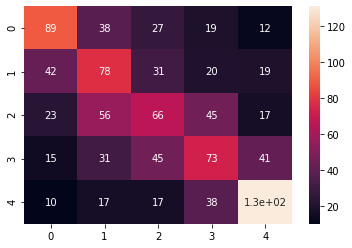

In [209]:
import seaborn as sns
sns.heatmap(cnf_matrix, annot=True)


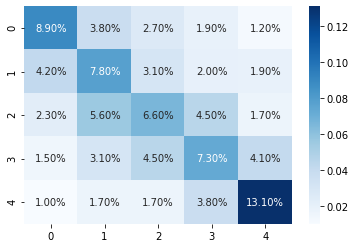

In [210]:

#percentage of my data is represented in each quadrant
sns.heatmap(cnf_matrix/np.sum(cnf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

<h2>Experimenting with different regularization strategies</h2>
<p>There are many different ways to mitigate overfitting in a neural network, collectively known as <em>regularization</em> techniques. One common regularization technique is called <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout">Dropout</a>. In this regularization method, a set of neurons is randomly selected at each training step to be completely ignored. This is done so that the neurons in our network do not rely strongly on their neighboring neurons and we avoid the creation of <a href="http://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf">"co-adaptations"</a> that do not generalize well to unseen data. This making the model more robust and less prone to overffiting.</p>
<p>You can create dropouts in <code>keras</code> by adding a layer named <code>Dropout(p)</code>, where <code>p</code> is the probability of dropping neurons in the previous layer. For example, the following model would implement dropout by removing roughly 20% percent of the outputs of the embedding layer at each training step:</p>

In [247]:
model2 = Sequential()
model2.add(Embedding(20000, 128, input_length=116))
model2.add(Dropout(0.2)) # --------------------------->Dropout layer will affect the output of previous layer.
model2.add(Dense(128, activation='relu')) 
model2.add(Dense(128, activation='relu'))
model2.add(GlobalMaxPooling1D())
model2.add(Dense(5, activation='sigmoid'))
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.fit(train_sequences, labels, validation_split=0.2, epochs=10)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 1.5887 - acc: 0.2516 - val_loss: 1.5359 - val_acc: 0.3275
Epoch 2/10
3200/3200 [==============================] - 4s 1ms/sample - loss: 1.4312 - acc: 0.3887 - val_loss: 1.3404 - val_acc: 0.4275
Epoch 3/10
3200/3200 [==============================] - 4s 1ms/sample - loss: 1.1987 - acc: 0.5056 - val_loss: 1.2788 - val_acc: 0.4550
Epoch 4/10
3200/3200 [==============================] - 4s 1ms/sample - loss: 0.9507 - acc: 0.6256 - val_loss: 1.3076 - val_acc: 0.4663
Epoch 5/10
3200/3200 [==============================] - 5s 1ms/sample - loss: 0.7081 - acc: 0.7362 - val_loss: 1.4171 - val_acc: 0.4487
Epoch 6/10
3200/3200 [==============================] - 5s 1ms/sample - loss: 0.4717 - acc: 0.8534 - val_loss: 1.5863 - val_acc: 0.4588
Epoch 7/10
3200/3200 [==============================] - 5s 1ms/sample - loss: 0.2877 - acc: 0.9162 - val_loss: 1.8242 - val_acc: 0.4375
E

<h3>Exercise 4:</h3>
<p>Modify the neural network definition above to try and fix the overfitting problem using Dropout. Explain the configuration that you tried and your results. Why do you think your modifications were or were not able to mitigate the overfitting problem?</p>

**Answer.**

In [252]:
y_test = test.Score.to_numpy()
loss ,acc = model2.evaluate(test_sequences, y_test)

print("Accurancy: ", acc)

1000/1000 [==============================] - 0s 160us/sample - loss: 2.2815 - acc: 0.4560
Accurancy:  0.456


Results vary given the stochastic nature of the algorithm, therefore it was considered to run the example several times and compare the average result. In this case, 5 tests are carried out

In [238]:
p1 = [0.455, 0.45, 0.45, 0.449, 0.457]
np.mean(p1)

0.45220000000000005

We can see that for this case and for the chosen configuration, the use of dropout in the hidden layers raised the performance.

In [249]:
#We modify the output value to 0.3
model3 = Sequential()
model3.add(Embedding(20000, 128, input_length=116))
model3.add(Dropout(0.3)) # --------------------------->Dropout layer will affect the output of previous layer.
model3.add(Dense(128, activation='relu')) 
model3.add(Dense(128, activation='relu'))
model3.add(GlobalMaxPooling1D())
model3.add(Dense(5, activation='sigmoid'))
model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.fit(train_sequences, labels, validation_split=0.2, epochs=10)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 1.5962 - acc: 0.2463 - val_loss: 1.5592 - val_acc: 0.3025
Epoch 2/10
3200/3200 [==============================] - 4s 1ms/sample - loss: 1.4780 - acc: 0.3537 - val_loss: 1.4079 - val_acc: 0.3963
Epoch 3/10
3200/3200 [==============================] - 4s 1ms/sample - loss: 1.2700 - acc: 0.4712 - val_loss: 1.3073 - val_acc: 0.4250
Epoch 4/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 1.0408 - acc: 0.5819 - val_loss: 1.2880 - val_acc: 0.4613
Epoch 5/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 0.8108 - acc: 0.6956 - val_loss: 1.3460 - val_acc: 0.4913
Epoch 6/10
3200/3200 [==============================] - 5s 1ms/sample - loss: 0.5903 - acc: 0.7947 - val_loss: 1.4954 - val_acc: 0.4512
Epoch 7/10
3200/3200 [==============================] - 5s 1ms/sample - loss: 0.3851 - acc: 0.8825 - val_loss: 1.6226 - val_acc: 0.4487
E

In [250]:
y_test = test.Score.to_numpy()
loss ,acc = model3.evaluate(test_sequences, y_test)

print("Accurancy: ", acc)

1000/1000 [==============================] - 0s 155us/sample - loss: 2.1703 - acc: 0.4410
Accurancy:  0.441


In [251]:
p2 =[0.451, 0.457, 0.454, 0.419, 0.441 ]
np.mean(p2)

0.4444


In this configuration it is observed that for the chosen configuration, the use of dropout = 0.3 in the hidden layers reduced the performance with respect to dropout = 0.2. But the performance is still better than the base model.

In [257]:
#We modify the output value to 0.4
model4 = Sequential()
model4.add(Embedding(20000, 128, input_length=116))
model4.add(Dropout(0.4)) # --------------------------->Dropout layer will affect the output of previous layer.
model4.add(Dense(128, activation='relu')) 
model4.add(Dense(128, activation='relu'))
model4.add(GlobalMaxPooling1D())
model4.add(Dense(5, activation='sigmoid'))
model4.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model4.fit(train_sequences, labels, validation_split=0.2, epochs=10)
y_test = test.Score.to_numpy()
loss ,acc = model4.evaluate(test_sequences, y_test)

print("Accurancy: ", acc)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 1.6032 - acc: 0.2375 - val_loss: 1.5811 - val_acc: 0.3300
Epoch 2/10
3200/3200 [==============================] - 4s 1ms/sample - loss: 1.5288 - acc: 0.3194 - val_loss: 1.4582 - val_acc: 0.3650
Epoch 3/10
3200/3200 [==============================] - 5s 1ms/sample - loss: 1.3506 - acc: 0.4184 - val_loss: 1.3503 - val_acc: 0.4000
Epoch 4/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 1.1660 - acc: 0.5184 - val_loss: 1.2847 - val_acc: 0.4675
Epoch 5/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 0.9695 - acc: 0.6222 - val_loss: 1.2995 - val_acc: 0.4638
Epoch 6/10
3200/3200 [==============================] - 5s 1ms/sample - loss: 0.7757 - acc: 0.7191 - val_loss: 1.4014 - val_acc: 0.4512
Epoch 7/10
3200/3200 [==============================] - 5s 1ms/sample - loss: 0.5825 - acc: 0.8041 - val_loss: 1.5897 - val_acc: 0.4300
E

In [258]:
p3 = [0.45, 0.455, 0.438, 0.441, 0.44]
np.mean(p3)

0.44480000000000003

**Answer.**
Taking into account the previous tests, the Dropout values of 0.2, 0.3 and 0.4 were used. Where it was achieved that the highest accuracy was 0.45 using a dropout value = 0.2 ... in this case it may be that using a low dropout value of around 20% constitutes a good starting point. If too low a value is used, the effect of the model's precision is minimal, but if we use a high droput value, we are eliminating many neurons, therefore we have a low learning value in the network.


<h3>Exercise 5:</h3>
<p>Keras allows you to add <a href="https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/l1">L1</a>, <a href="https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/l2">L2</a>, or <a href="https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/l1_l2">L1 and L2</a> combined regularizers on individual layers by passing in the <code>kernel_regularizer</code>, <code>bias_regularizer</code> or <code>activity_regularizer</code> arguments. In neural networks, these regularizers work by penalizing the loss function in different ways, based on the number of weights or the size of the weights.</p>
<p>Try 4-5 different combinations of L1, L2, L1 and L2 regularization in different combinations on different layers. In each example, explain why you tried that configuration and the results. Why do you think your modifications were or were not able to mitigate the overfitting problem?</p>

**Answer.**

In [311]:
#layer1 = tf.keras.layers.Dense(128, kernel_regularizer='l1',activation='relu')
from tensorflow.keras import layers
from tensorflow.keras import regularizers

# This is the first combination l1_l2
layer1= layers.Dense(
    units=128,
    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4),
    activity_regularizer=regularizers.l2(1e-5)
)

In [312]:
model5 = Sequential()
model5.add(Embedding(20000, 128, input_length=116))
model5.add(Dropout(0.2)) # --------------------------->Dropout layer will affect the output of previous layer.
model5.add(layer1) 
model5.add(Dense(128, activation='relu'))
model5.add(GlobalMaxPooling1D())
model5.add(Dense(5, activation='sigmoid'))
model5.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model5.fit(train_sequences, labels, validation_split=0.2, epochs=10)


Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 1.6069 - acc: 0.2684 - val_loss: 1.5474 - val_acc: 0.3375
Epoch 2/10
3200/3200 [==============================] - 5s 1ms/sample - loss: 1.3978 - acc: 0.4263 - val_loss: 1.3486 - val_acc: 0.4200
Epoch 3/10
3200/3200 [==============================] - 4s 1ms/sample - loss: 1.1370 - acc: 0.5519 - val_loss: 1.2775 - val_acc: 0.4737
Epoch 4/10
3200/3200 [==============================] - 4s 1ms/sample - loss: 0.8705 - acc: 0.6881 - val_loss: 1.3362 - val_acc: 0.4700
Epoch 5/10
3200/3200 [==============================] - 5s 1ms/sample - loss: 0.6150 - acc: 0.7997 - val_loss: 1.5054 - val_acc: 0.4575
Epoch 6/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 0.4111 - acc: 0.8875 - val_loss: 1.6824 - val_acc: 0.4563
Epoch 7/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 0.2618 - acc: 0.9441 - val_loss: 1.8538 - val_acc: 0.4688
E

In [315]:
y_test = test.Score.to_numpy()
loss ,acc = model5.evaluate(test_sequences, y_test)

1000/1000 [==============================] - 0s 185us/sample - loss: 2.3995 - acc: 0.4590


**Answer**
In this first test we tested the l1_l2 configuration in the first layer and the same results were obtained from the reference model. That is, an accuracy of aproximaty 46% was obtained

In [313]:

# This is the second test combination l1_l2
layer2= layers.Dense(
    units=128,
    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4),
    activity_regularizer=regularizers.l2(1e-5)
)


model6 = Sequential()
model6.add(Embedding(20000, 128, input_length=116))
model6.add(Dropout(0.2)) # --------------------------->Dropout layer will affect the output of previous layer.
model6.add(Dense(128, activation='relu')) 
model6.add(layer2)
model6.add(GlobalMaxPooling1D())
model6.add(Dense(5, activation='sigmoid'))
model6.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model6.fit(train_sequences, labels, validation_split=0.2, epochs=10)


Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 1.6206 - acc: 0.2444 - val_loss: 1.5863 - val_acc: 0.3262
Epoch 2/10
3200/3200 [==============================] - 4s 1ms/sample - loss: 1.4710 - acc: 0.3866 - val_loss: 1.3599 - val_acc: 0.4075
Epoch 3/10
3200/3200 [==============================] - 4s 1ms/sample - loss: 1.2428 - acc: 0.4822 - val_loss: 1.3313 - val_acc: 0.4475
Epoch 4/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 0.9989 - acc: 0.6103 - val_loss: 1.3488 - val_acc: 0.4588
Epoch 5/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 0.7772 - acc: 0.7212 - val_loss: 1.4796 - val_acc: 0.4412
Epoch 6/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 0.5438 - acc: 0.8356 - val_loss: 1.6901 - val_acc: 0.4387
Epoch 7/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 0.3781 - acc: 0.9006 - val_loss: 1.8696 - val_acc: 0.4313
E

In [318]:
y_test = test.Score.to_numpy()
loss ,acc = model6.evaluate(test_sequences, y_test)

1000/1000 [==============================] - 0s 193us/sample - loss: 2.6039 - acc: 0.4210


**Answer**
In this test the same configuration is used but on the second layer, in this case it is observed that the precision of the model decreased to 44.5%.

In [325]:
#layer1 = tf.keras.layers.Dense(128, kernel_regularizer='l1',bias_regularizer='l2',activation='relu')
#layer2 = tf.keras.layers.Dense(128, kernel_regularizer='l2',bias_regularizer='l2',activation='relu')

# This is the third test combination l1_l2

layer1= layers.Dense(
    units=128,
    kernel_regularizer=regularizers.l1(1e-5),
    bias_regularizer=regularizers.l1(1e-5),
    activity_regularizer=regularizers.l1(1e-5)
)

model7 = Sequential()
model7.add(Embedding(20000, 128, input_length=116))
model7.add(Dropout(0.2)) # --------------------------->Dropout layer will affect the output of previous layer.
model7.add(layer1) 
model7.add(layer1)
model7.add(GlobalMaxPooling1D())
model7.add(Dense(5, activation='sigmoid'))
model7.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model7.fit(train_sequences, labels, validation_split=0.2, epochs=10)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 1.6003 - acc: 0.2728 - val_loss: 1.5366 - val_acc: 0.3375
Epoch 2/10
3200/3200 [==============================] - 5s 1ms/sample - loss: 1.4243 - acc: 0.4147 - val_loss: 1.3794 - val_acc: 0.4000
Epoch 3/10
3200/3200 [==============================] - 5s 1ms/sample - loss: 1.1436 - acc: 0.5572 - val_loss: 1.2578 - val_acc: 0.4750
Epoch 4/10
3200/3200 [==============================] - 5s 1ms/sample - loss: 0.8709 - acc: 0.6909 - val_loss: 1.2854 - val_acc: 0.4888
Epoch 5/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 0.5984 - acc: 0.8175 - val_loss: 1.4052 - val_acc: 0.4775
Epoch 6/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 0.3807 - acc: 0.8959 - val_loss: 1.5878 - val_acc: 0.4837
Epoch 7/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 0.2257 - acc: 0.9584 - val_loss: 1.7977 - val_acc: 0.4775
E

In [326]:
y_test = test.Score.to_numpy()
loss ,acc = model7.evaluate(test_sequences, y_test)

1000/1000 [==============================] - 0s 207us/sample - loss: 2.2957 - acc: 0.4690


**Answer**
In this case  we agregate the configuration of l1 regularization to both layers. We can obseve that the accuary of the model improve to aproximately to 47 %.

In [329]:
# This is the third test combination l1_l2

layer1_1= layers.Dense(
    units=128,
    kernel_regularizer=regularizers.l2(1e-5),
    bias_regularizer=regularizers.l2(1e-4),
    activity_regularizer=regularizers.l2(1e-5)
)

layer2_2= layers.Dense(
    units=128,
    kernel_regularizer=regularizers.l1(1e-5),
    bias_regularizer=regularizers.l1(1e-4),
    activity_regularizer=regularizers.l1(1e-5)
)



model8 = Sequential()
model8.add(Embedding(20000, 128, input_length=116))
model8.add(Dropout(0.2)) # --------------------------->Dropout layer will affect the output of previous layer.
model8.add(layer1_1) 
model8.add(layer2_2)
model8.add(GlobalMaxPooling1D())
model8.add(Dense(5, activation='sigmoid'))
model8.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model8.fit(train_sequences, labels, validation_split=0.2, epochs=10)

Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 1.6065 - acc: 0.2691 - val_loss: 1.5588 - val_acc: 0.3275
Epoch 2/10
3200/3200 [==============================] - 5s 1ms/sample - loss: 1.4146 - acc: 0.4219 - val_loss: 1.3727 - val_acc: 0.4175
Epoch 3/10
3200/3200 [==============================] - 5s 1ms/sample - loss: 1.1391 - acc: 0.5519 - val_loss: 1.2908 - val_acc: 0.4762
Epoch 4/10
3200/3200 [==============================] - 5s 1ms/sample - loss: 0.8661 - acc: 0.6922 - val_loss: 1.3525 - val_acc: 0.4650
Epoch 5/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 0.6041 - acc: 0.8037 - val_loss: 1.4809 - val_acc: 0.4675
Epoch 6/10
3200/3200 [==============================] - 6s 2ms/sample - loss: 0.3775 - acc: 0.8978 - val_loss: 1.7293 - val_acc: 0.4487
Epoch 7/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 0.2233 - acc: 0.9594 - val_loss: 1.9410 - val_acc: 0.4375
E

In [384]:
y_test = test.Score.to_numpy()
loss ,acc = model8.evaluate(test_sequences, y_test)

1000/1000 [==============================] - 0s 205us/sample - loss: 2.3311 - acc: 0.4420


**Answer**
Finally to this case I use the two configurations to the layers. The first layer use the  l2 regularization and to the second layer I use the l1 regularization. We can observed that the accuracy of the model is 44.2%  

<h2>Regularization through adding more data</h2>
<p>Depending on the configurations you tried above, you probably saw that L1 and L2 regularization are pretty limited for this model and this amount of data. A more straightforward way to prevent overfitting is simply by adding more training data. If the network has more (and more varied) examples to learn from, perhaps it will learn more generalizable rules.</p>

<h3>Exercise 6:</h3>
<p>How would you test the hypothesis that adding more data would result in a more generalizable model? Explain any change in results you see from further experimentation.</p>
<p><strong>Hint:</strong> Try adding 6000 reviews for each score instead. Compare with the original proposed model.</p>

**Answer.**

In [402]:
# we rwalize the same procedure to take 6000 reviews
score_one  = amazon_review[amazon_review["Score"]==1][0:6000]
score_one["Score"]=0
score_two  = amazon_review[amazon_review["Score"]==2][0:6000]
score_two["Score"]=1
score_three  = amazon_review[amazon_review["Score"]==3][0:6000]
score_three["Score"]=2
score_four  = amazon_review[amazon_review["Score"]==4][0:6000]
score_four["Score"]=3
score_five  = amazon_review[amazon_review["Score"]==5][0:6000]
score_five["Score"]=4


scores_6000 = pd.concat([score_one,score_two,score_three,score_four,score_five],ignore_index= True)

# Now  I divided the dataset in two groups: Train and Test    random_state = 0
train_6000, test_6000 = train_test_split(scores_6000, test_size = 0.2, random_state = np.random.seed(1337))

In [403]:
x_train_6000 = train_6000.Text
y_train_6000 = train_6000.Score
x_test_6000 = test_6000.Text
y_test_6000 = test_6000.Score


In [404]:

tokenizer_6000 = Tokenizer(num_words=20000)
tokenizer_6000.fit_on_texts(x_train_6000)  #Then, we create the text->indices mapping.

# we use the tokenizer to transform the texts in our train data to sequences
sequence_train_6000 = tokenizer_6000.texts_to_sequences(x_train_6000)
train_sequences_6000 = tf.keras.preprocessing.sequence.pad_sequences(sequence_train_6000,maxlen=116)
train_sequences_6000.shape

(24000, 116)

In [405]:
# we realize the same procedure with the  test set
sequence_test_6000= tokenizer_6000.texts_to_sequences(x_test_6000)
# We obtein the array
test_sequences_6000 = tf.keras.preprocessing.sequence.pad_sequences(sequence_test_6000,maxlen=116)
test_sequences_6000.shape


(6000, 116)

In [406]:
# We create the network
model_new = Sequential()
model_new.add(Embedding(20000, 128, input_length=116))
model_new.add(Dropout(0.2)) # --------------------------->Dropout layer will affect the output of previous layer.
model_new.add(Dense(128, activation='relu'))
model_new.add(Dense(128, activation='relu'))
model_new.add(GlobalMaxPooling1D())
model_new.add(Dense(5, activation='sigmoid'))
model_new.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

labels1 = np.array(np.array(y_train_6000))


In [407]:
model_new.fit(train_sequences_6000, labels1, validation_split=0.2, epochs=10)

Train on 19200 samples, validate on 4800 samples
Epoch 1/10
19200/19200 [==============================] - 29s 2ms/sample - loss: 1.3927 - acc: 0.3800 - val_loss: 1.2470 - val_acc: 0.4640
Epoch 2/10
19200/19200 [==============================] - 30s 2ms/sample - loss: 1.1540 - acc: 0.5128 - val_loss: 1.1866 - val_acc: 0.4940
Epoch 3/10
19200/19200 [==============================] - 30s 2ms/sample - loss: 1.0188 - acc: 0.5820 - val_loss: 1.2048 - val_acc: 0.5042
Epoch 4/10
19200/19200 [==============================] - 30s 2ms/sample - loss: 0.8921 - acc: 0.6452 - val_loss: 1.2999 - val_acc: 0.4885
Epoch 5/10
19200/19200 [==============================] - 30s 2ms/sample - loss: 0.7775 - acc: 0.6993 - val_loss: 1.3431 - val_acc: 0.5002
Epoch 6/10
19200/19200 [==============================] - 30s 2ms/sample - loss: 0.6599 - acc: 0.7505 - val_loss: 1.4439 - val_acc: 0.5000
Epoch 7/10
19200/19200 [==============================] - 30s 2ms/sample - loss: 0.5586 - acc: 0.7958 - val_loss: 1.5

In [376]:
y_test_c = y_test_6000.to_numpy()
loss ,acc = model.evaluate(test_sequences_6000, y_test_c)

print("Accurancy: ", acc)

6000/6000 [==============================] - 1s 172us/sample - loss: 3.7913 - acc: 0.2173
Accurancy:  0.21733333



**Answer**

In this case it is observed that when adding more data, a worse accuracy is obtained. The original model propous had a better accuracity

<h2>Regularization through early stopping</h2>
<p>We have consistently seen that our neural network overfits at around the third epoch. Hence, another form of regularization is to end training early if validation loss starts increasing. (This is similar to the validation curves we used when constructing classification models.) Although the network will not have found an optimal function in the training data, the looser function that it has found will likely be more generalizable.</p>
<p>You can do this manually by inspecting the data as we have done above and modifying the <code>epochs</code> argument in <code>fit()</code>, but Keras also allows you to easily do this automatically via an <a href="https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping"><code>EarlyStopping</code> callback</a>.</p>

<h3>Exercise 7:</h3>
<p>Experiment with the <code>EarlyStopping</code> callback and explain the results.</p>

**Answer.**

In [408]:

# In this case we use the model with better accuracity

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

In [409]:
layer1= layers.Dense(
    units=128,
    kernel_regularizer=regularizers.l1(1e-5),
    bias_regularizer=regularizers.l1(1e-5),
    activity_regularizer=regularizers.l1(1e-5)
)

model_e = Sequential()
model_e.add(Embedding(20000, 128, input_length=116))
model_e.add(Dropout(0.2)) # --------------------------->Dropout layer will affect the output of previous layer.
model_e.add(layer1) 
model_e.add(layer1)
model_e.add(GlobalMaxPooling1D())
model_e.add(Dense(5, activation='sigmoid'))
model_e.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model_e.fit(train_sequences, labels, validation_split=0.2, epochs=10, callbacks=[callback])

len(history.history['loss'])  # Only 4 epochs are run.


Train on 3200 samples, validate on 800 samples
Epoch 1/10
3200/3200 [==============================] - 7s 2ms/sample - loss: 1.6093 - acc: 0.2744 - val_loss: 1.5532 - val_acc: 0.3762
Epoch 2/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 1.4313 - acc: 0.4238 - val_loss: 1.3523 - val_acc: 0.4212
Epoch 3/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 1.1420 - acc: 0.5603 - val_loss: 1.2826 - val_acc: 0.4712
Epoch 4/10
3200/3200 [==============================] - 5s 2ms/sample - loss: 0.8467 - acc: 0.7003 - val_loss: 1.3383 - val_acc: 0.4450


4

**Answer**

In this case the overfitting starts from the 4th epotch, but the result i simular always the acuracy keep aroun 0.45 

In [410]:
y_test = test.Score.to_numpy()
loss ,acc = model_e.evaluate(test_sequences, y_test)

1000/1000 [==============================] - 0s 217us/sample - loss: 1.3738 - acc: 0.4490


<h2>Evaluating our model</h2>

<p>Unlike in most previous cases, we used <em>three</em> splits of our data instead of two. All of our model tuning has been done on the validation set, and we have not even touched the test set that we split off right at the start.</p>
<p>For experiments, it's very important that your model is only run <strong>once</strong> on your test set. As there is so much randomness at play, it's vital to not "cherry-pick" the best results, so optimize as much as you want on the validation set, but keep the test set until the end and all official results should be based on the single run of the test set (or whatever configuration was decided <em>before the experiment started</em>).</p>

<h3>Exercise 8:</h3>
<p>Let's take the model configuration that resulted in the highest validation accuracy and use that one as our final model. Evaluate this configuration on how well it performs on the test set, and furthermore diagnose <em>what kinds of mistakes it makes</em>. Explain whether these mistakes are expected or not, and print some of these poorly classified reviews. Given the mistakes the model made, how would you then go back and try to improve the model or optimize the tuning steps?</p>
<p><strong>Hint:</strong> You can use the <a href="https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#predict_classes"><code>predict_classes</code></a> method on your model to get the most probable class directly.</p>

**Answer.**

<p>Hopefully, you have seen from this that there is no one-size-fits-all method when creating model architectures or tuning parameters. Often times, copious experimentation is needed, and even then it can be difficult to get significantly better results than a baseline model or even really diagnose what is going wrong under the hood (since neural networks are so "black-box"). In many cases, the quantity and quality of the data itself is far more important than the architecture of the network for getting good results.</p>